In [ ]:
#@title Package Loading
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
import matplotlib.ticker as mticker
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from pandas.plotting import register_matplotlib_converters
from collections import Counter
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import precision_score, recall_score, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import cvxpy as cp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns
%matplotlib inline
from datetime import datetime
from dateutil.relativedelta import relativedelta
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

# Macrofactors

In [ ]:
# Macrofactor - Inflation
start_CPI = datetime(1987, 3, 1)
end_CPI = datetime(2024, 3, 31)

core_CPI = pdr.get_data_fred('CPILFESL', start_CPI, end_CPI)

# Trailing one-year annualized changes in core CPI
core_CPI['1yr Annualized Change'] = core_CPI['CPILFESL'].pct_change(12).apply(lambda x: (1 + x) ** 1 - 1)

# Trailing ten-year annualized changes in core CPI
core_CPI['10yr Annualized Change'] = core_CPI['CPILFESL'].pct_change(120).apply(lambda x: (1 + x) ** (1/10) - 1)

core_CPI=core_CPI.drop(columns=['CPILFESL'])
core_CPI.tail()

,1yr Annualized Change,10yr Annualized Change
DATE,,
2023-11-01,0.040151,0.028705
2023-12-01,0.039101,0.028813
2024-01-01,0.038747,0.029128
2024-02-01,0.037620,0.029399
2024-03-01,0.037973,0.029576


In [ ]:
# Macrofactor - GDP Growth
start_GDP = datetime(1987, 3, 1)
end_GDP = datetime(2024, 3, 31)

# US Real GDP Growth
GDP_Growth = pdr.get_data_fred('A191RL1Q225SBEA', start_GDP, end_GDP)
GDP_Growth.columns = ['GDP Growth']

GDP_Growth = GDP_Growth.resample('MS').bfill()

GDP_Growth.tail()

,GDP Growth
DATE,
2023-09-01,3.4
2023-10-01,3.4
2023-11-01,1.6
2023-12-01,1.6
2024-01-01,1.6


In [ ]:
# Macrofactor - Business Cycle
start_cycle = datetime(1987, 3, 1)
end_cycle = datetime(2024, 3, 31)

# Leading Economic Index
lei_data = pdr.get_data_fred('USALOLITONOSTSAM', start_cycle, end_cycle).resample('MS').bfill()
lei_data.columns=['Leading']

# Coincident Economic Index
cei_data = pdr.get_data_fred('USPHCI',start_cycle, end_cycle).resample('MS').bfill()
cei_data.columns=['Coincident']

# Lagging Economic Index - Average Duration of Unemployment
lag_data_unemployment = pdr.get_data_fred('UEMPMEAN', start_cycle, end_cycle).resample('MS').bfill()
lag_data_unemployment.columns=['Lagging - Unemployment']

# Lagging Economic Index - Labor Cost Per Unit of Output
lag_data_labor_cost = pdr.get_data_fred('ULCNFB', start_cycle, end_cycle).resample('MS').bfill()
lag_data_labor_cost.columns=['Lagging - Labor Cost']

# Lagging Economic Index - Ratio of Consumer Installment Credit to Personal Income
total_credit = pdr.get_data_fred('TOTALSL', start_cycle, end_cycle)
personal_income = pdr.get_data_fred('PI', start_cycle, end_cycle)
lag_data_credit_income_ratio = total_credit['TOTALSL'] / personal_income['PI']
lag_data_credit_income_ratio = pd.DataFrame(lag_data_credit_income_ratio, columns=['Lagging - Credit Income Ratio']).resample('MS').bfill()

Business_Cycle = pd.concat([lei_data,cei_data,lag_data_unemployment,lag_data_labor_cost,lag_data_credit_income_ratio],axis=1)
Business_Cycle = Business_Cycle.dropna()
Business_Cycle.tail()

,Leading,Coincident,Lagging - Unemployment,Lagging - Labor Cost,Lagging - Credit Income Ratio
DATE,,,,,
2023-06-01,99.22750,139.70,20.7,119.882,0.217509
2023-07-01,99.33507,140.08,20.6,119.882,0.217423
2023-08-01,99.42046,140.22,20.4,119.990,0.215681
2023-09-01,99.48235,140.61,21.4,119.990,0.215277
2023-10-01,99.53435,140.91,21.6,119.990,0.215155


In [ ]:
# Macrofactor - Financial Condition
# Risk
nfcirisk_data = pdr.get_data_fred('NFCIRISK', start_cycle, end_cycle)
nfcirisk_data = nfcirisk_data.resample('M').mean()
nfcirisk_data.columns=['Risk']
nfcirisk_data.index = nfcirisk_data.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# Credit
nfcicredit_data = pdr.get_data_fred('NFCICREDIT', start_cycle, end_cycle)
nfcicredit_data = nfcicredit_data.resample('M').mean()
nfcicredit_data.columns = ['Credit']
nfcicredit_data.index = nfcicredit_data.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# Leverage
nfcileverage_data = pdr.get_data_fred('NFCILEVERAGE', start_cycle, end_cycle)
nfcileverage_data = nfcileverage_data.resample('M').mean()
nfcileverage_data.columns = ['Leverage']
nfcileverage_data.index = nfcileverage_data.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

Financial_Condition = pd.concat([nfcirisk_data,nfcicredit_data,nfcileverage_data],axis=1)
Financial_Condition.tail()

,Risk,Credit,Leverage
DATE,,,
2023-11-01,-0.465290,0.095395,-0.205702
2023-12-01,-0.516504,0.046750,-0.452158
2024-01-01,-0.555260,-0.002270,-0.378827
2024-02-01,-0.557770,-0.032090,-0.138148
2024-03-01,-0.558660,-0.061530,-0.003104


In [ ]:
# Macrofactor - Monetary Policy Expectations
# Effective Federal Funds Rate
effr_data = pdr.get_data_fred('DFF',start_cycle, end_cycle)
monthly_effr_data = effr_data.resample('M').mean()
monthly_effr_data.columns = ['Effective Federal Funds Rate']
monthly_effr_data.index = monthly_effr_data.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

# VIX
VIX_data = pdr.get_data_fred('VIXCLS',start_cycle, end_cycle)
monthly_VIX_data = VIX_data.resample('M').mean()
monthly_VIX_data.columns = ['Volatility Index']
monthly_VIX_data.index = monthly_VIX_data.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)

Monetary_Expectation = pd.concat([monthly_effr_data,monthly_VIX_data],axis=1)
Monetary_Expectation.tail()

,Effective Federal Funds Rate,Volatility Index
DATE,,
2023-11-01,5.33,14.019091
2023-12-01,5.33,12.718500
2024-01-01,5.33,13.388636
2024-02-01,5.33,13.980476
2024-03-01,5.33,13.787500


In [ ]:
# Equity Earning Yield - CAPE ratio
CAPE_Ratio = pd.read_excel('/content/drive/MyDrive/CAPE Ratio.xlsx')
CAPE_Ratio.set_index('Date',inplace=True)
CAPE_Ratio.tail()

,CAPE Ratio
Date,
2023-11-01,30.08
2023-12-01,31.59
2024-01-01,32.19
2024-02-01,33.34
2024-03-01,34.37


In [ ]:
# Macrofactor Combination
whole_macrofactor = pd.concat([core_CPI,GDP_Growth,Business_Cycle,Financial_Condition,Monetary_Expectation,CAPE_Ratio],axis=1)
whole_macrofactor

,1yr Annualized Change,10yr Annualized Change,GDP Growth,Leading,Coincident,Lagging - Unemployment,Lagging - Labor Cost,Lagging - Credit Income Ratio,Risk,Credit,Leverage,Effective Federal Funds Rate,Volatility Index,CAPE Ratio
1987-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.142285,-0.225763,0.524895,6.128387,NaN,16.43
1987-04-01,NaN,NaN,4.4,100.6614,57.61,14.8,64.819,0.169376,0.413312,-0.284195,0.371145,6.365333,NaN,16.20
1987-05-01,NaN,NaN,3.5,100.8100,57.77,14.9,65.467,0.168467,0.935656,-0.290678,0.258324,6.852903,NaN,16.16
1987-06-01,NaN,NaN,3.5,100.9134,57.96,14.9,65.467,0.169119,0.890685,-0.254195,0.189705,6.725000,NaN,16.83
1987-07-01,NaN,NaN,3.5,100.9546,58.18,14.2,65.467,0.169367,0.517720,-0.260212,0.216124,6.582258,NaN,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,0.040151,0.028705,1.6,NaN,NaN,NaN,NaN,NaN,-0.465290,0.095395,-0.205702,5.330000,14.019091,30.08
2023-12-01,0.039101,0.028813,1.6,NaN,NaN,NaN,NaN,NaN,-0.516504,0.046750,-0.452158,5.330000,12.718500,31.59
2024-01-01,0.038747,0.029128,1.6,NaN,NaN,NaN,NaN,NaN,-0.555260,-0.002270,-0.378827,5.330000,13.388636,32.19
2024-02-01,0.037620,0.029399,NaN,NaN,NaN,NaN,NaN,NaN,-0.557770,-0.032090,-0.138148,5.330000,13.980476,33.34


In [ ]:
whole_macrofactor.dropna()

,1yr Annualized Change,10yr Annualized Change,GDP Growth,Leading,Coincident,Lagging - Unemployment,Lagging - Labor Cost,Lagging - Credit Income Ratio,Risk,Credit,Leverage,Effective Federal Funds Rate,Volatility Index,CAPE Ratio
1997-03-01,0.024331,0.037443,6.8,100.22910,77.34,15.5,79.249,0.181609,-0.673890,-0.225110,-1.010110,5.386129,20.170000,28.80
1997-04-01,0.026124,0.037130,6.8,100.35690,77.63,15.6,79.249,0.182722,-0.609858,-0.217647,-0.931277,5.507333,19.662273,27.58
1997-05-01,0.025455,0.036961,5.1,100.48460,77.92,15.4,79.397,0.182634,-0.566322,-0.228264,-0.860316,5.504194,19.924762,29.93
1997-06-01,0.024184,0.036907,5.1,100.60700,78.12,15.5,79.397,0.182333,-0.572653,-0.218092,-0.839975,5.555667,20.194286,31.25
1997-07-01,0.024140,0.036740,5.1,100.71420,78.39,16.4,79.397,0.182245,-0.609495,-0.217640,-0.796223,5.521290,20.529091,32.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.048552,0.028227,4.9,99.22750,139.70,20.7,119.882,0.217509,-0.370814,0.127450,0.642882,5.076333,14.003182,29.94
2023-07-01,0.047076,0.028227,4.9,99.33507,140.08,20.6,119.882,0.217423,-0.390880,0.107582,0.491735,5.120000,13.932381,30.89
2023-08-01,0.044128,0.028263,3.4,99.42046,140.22,20.4,119.990,0.215681,-0.438792,0.095690,0.219392,5.330000,15.853913,30.09
2023-09-01,0.041437,0.028431,3.4,99.48235,140.61,21.4,119.990,0.215277,-0.448002,0.095146,0.088614,5.330000,15.173333,29.80


In [ ]:
month_counts = whole_macrofactor.groupby(whole_macrofactor.index.year).apply(lambda x: x.index.month.nunique())
month_counts == 12

1987    False
1988     True
1989     True
1990     True
1991     True
1992     True
1993     True
1994     True
1995     True
1996     True
1997     True
1998     True
1999     True
2000     True
2001     True
2002     True
2003     True
2004     True
2005     True
2006     True
2007     True
2008     True
2009     True
2010     True
2011     True
2012     True
2013     True
2014     True
2015     True
2016     True
2017     True
2018     True
2019     True
2020     True
2021     True
2022     True
2023     True
2024    False
dtype: bool

# Financial Turbulence

In [ ]:
# SP500
tickers = {
    'XLK': 'Info Tech',   # Technology
    'XLE': 'Energy',      # Energy
    'XLF': 'Financials',  # Financials
    'XLV': 'Healthcare',  # Healthcare
    'XLP': 'Staples',     # Consumer Staples
    'XLY': 'Discretionary',  # Consumer Discretionary
    'XLU': 'Utilities',   # Utilities
    'XLI': 'Industrials', # Industrials
    'XLB': 'Materials'    # Materials
}

SP500_data = yf.download(list(tickers.keys()), start="1987-03-01", end="2024-03-31", interval='1mo')

SP500_data = SP500_data['Adj Close']

SP500_data.rename(columns=tickers, inplace=True)

SP500_data.head()

[*********************100%%**********************]  9 of 9 completed


Ticker,Materials,Energy,Financials,Industrials,Info Tech,Staples,Utilities,Healthcare,Discretionary
Date,,,,,,,,,
1999-01-01,12.046218,11.466975,11.774715,15.491603,28.494753,14.911636,12.220731,18.904381,20.573193
1999-02-01,12.233472,11.368406,11.959908,15.631088,25.668819,14.755127,11.883968,18.926056,20.444468
1999-03-01,12.411805,12.929098,12.314840,15.900076,27.576321,14.711656,11.061481,19.424685,21.415785
1999-04-01,15.531145,14.896358,13.214025,18.359325,27.741165,14.223738,12.209855,20.118422,22.001366
1999-05-01,14.117599,14.574855,12.417159,17.999334,27.835348,14.075663,12.353268,19.500557,21.005568


In [ ]:
monthly_returns_SP500_data = SP500_data.pct_change().dropna()

monthly_returns_SP500_data.head()

Ticker,Materials,Energy,Financials,Industrials,Info Tech,Staples,Utilities,Healthcare,Discretionary
Date,,,,,,,,,
1999-02-01,0.015545,-0.008596,0.015728,0.009004,-0.099174,-0.010496,-0.027557,0.001147,-0.006257
1999-03-01,0.014577,0.137283,0.029677,0.017209,0.074312,-0.002946,-0.069210,0.026346,0.047510
1999-04-01,0.251320,0.152158,0.073016,0.154669,0.005978,-0.033165,0.103817,0.035714,0.027343
1999-05-01,-0.091014,-0.021583,-0.060305,-0.019608,0.003395,-0.010410,0.011746,-0.030711,-0.045261
1999-06-01,0.054499,0.015271,0.040499,0.060000,0.096024,0.013614,0.034828,0.043913,0.063023


In [ ]:
treasury_data = pdr.get_data_fred(['GS1', 'GS2', 'GS10'], start="1987-03-01", end="2024-03-31")
monthly_treasury_returns = treasury_data.resample('MS').bfill().pct_change().dropna()

monthly_treasury_returns.head()

,GS1,GS2,GS10
DATE,,,
1987-04-01,0.077944,0.093458,0.106207
1987-05-01,0.076923,0.105413,0.073566
1987-06-01,-0.028571,-0.024485,-0.024390
1987-07-01,-0.017647,-0.017173,0.005952
1987-08-01,0.052395,0.041667,0.036686


In [ ]:
sectors_returns = pd.concat([monthly_returns_SP500_data, monthly_treasury_returns], axis=1).dropna()
sectors_returns

,Materials,Energy,Financials,Industrials,Info Tech,Staples,Utilities,Healthcare,Discretionary,GS1,GS2,GS10
1999-02-01,0.015545,-0.008596,0.015728,0.009004,-0.099174,-0.010496,-0.027557,0.001147,-0.006257,0.042129,0.056277,0.059322
1999-03-01,0.014577,0.137283,0.029677,0.017209,0.074312,-0.002946,-0.069210,0.026346,0.047510,0.017021,0.034836,0.046000
1999-04-01,0.251320,0.152158,0.073016,0.154669,0.005978,-0.033165,0.103817,0.035714,0.027343,-0.018828,-0.013861,-0.009560
1999-05-01,-0.091014,-0.021583,-0.060305,-0.019608,0.003395,-0.010410,0.011746,-0.030711,-0.045261,0.034115,0.054217,0.069498
1999-06-01,0.054499,0.015271,0.040499,0.060000,0.096024,0.013614,0.034828,0.043913,0.063023,0.051546,0.070476,0.064982
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-01,0.083487,-0.007160,0.109394,0.088349,0.128956,0.041261,0.051432,0.054360,0.109665,-0.025830,-0.037475,-0.062500
2023-12-01,0.037981,-0.008749,0.047354,0.064830,0.039533,0.019389,0.009082,0.038611,0.059426,-0.060606,-0.086066,-0.106667
2024-01-01,-0.032214,0.004427,0.035954,-0.004232,0.029282,0.020030,-0.020545,0.033939,-0.042415,-0.034274,-0.031390,0.009950
2024-02-01,0.065077,0.032730,0.040764,0.071840,0.047046,0.020982,0.010578,0.031628,0.078926,0.027140,0.050926,0.036946


In [ ]:
# Mean
mean_sectors_returns = sectors_returns.mean()
mean_sectors_returns

Materials        0.008667
Energy           0.009734
Financials       0.006217
Industrials      0.008487
Info Tech        0.008832
Staples          0.006074
Utilities        0.006553
Healthcare       0.007661
Discretionary    0.008847
GS1              0.014100
GS2              0.010340
GS10             0.002930
dtype: float64

In [ ]:
# Covariance
covariance_sectors_returns = sectors_returns.cov()
covariance_sectors_returns

,Materials,Energy,Financials,Industrials,Info Tech,Staples,Utilities,Healthcare,Discretionary,GS1,GS2,GS10
Materials,0.003801,0.002902,0.002827,0.002938,0.002507,0.001187,0.001180,0.001677,0.002670,0.000021,0.000827,0.000535
Energy,0.002902,0.005512,0.002604,0.002591,0.002006,0.001079,0.001190,0.001334,0.001983,0.001399,0.002144,0.001511
Financials,0.002827,0.002604,0.003933,0.002833,0.002286,0.001317,0.001080,0.001660,0.002647,0.000490,0.001579,0.001039
Industrials,0.002938,0.002591,0.002833,0.003057,0.002520,0.001219,0.001133,0.001621,0.002522,0.000186,0.001099,0.000684
Info Tech,0.002507,0.002006,0.002286,0.002520,0.004404,0.000938,0.000839,0.001688,0.002736,0.000130,0.000815,0.000333
Staples,0.001187,0.001079,0.001317,0.001219,0.000938,0.001343,0.000965,0.000894,0.001099,-0.000020,0.000182,-0.000039
Utilities,0.001180,0.001190,0.001080,0.001133,0.000839,0.000965,0.001977,0.000821,0.000930,0.000087,0.000226,-0.000258
Healthcare,0.001677,0.001334,0.001660,0.001621,0.001688,0.000894,0.000821,0.001684,0.001571,-0.000523,0.000094,-0.000024
Discretionary,0.002670,0.001983,0.002647,0.002522,0.002736,0.001099,0.000930,0.001571,0.003175,-0.000159,0.000569,0.000182
GS1,0.000021,0.001399,0.000490,0.000186,0.000130,-0.000020,0.000087,-0.000523,-0.000159,0.027622,0.019044,0.006689


In [ ]:
def calculate_turbulence(row, mean_sectors_returns, inv_cov_matrix):
    diff = row - mean_sectors_returns
    return np.dot(np.dot(diff.T, inv_cov_matrix), diff)

inv_cov_matrix = np.linalg.inv(covariance_sectors_returns)

sectors_returns['Turbulence'] = sectors_returns.apply(calculate_turbulence, axis=1, args=(mean_sectors_returns, inv_cov_matrix))

sectors_returns[['Turbulence']]

,Turbulence
1999-02-01,7.347833
1999-03-01,12.435061
1999-04-01,53.038324
1999-05-01,8.995298
1999-06-01,3.727651
...,...
2023-11-01,7.694866
2023-12-01,5.589048
2024-01-01,9.188654
2024-02-01,3.469590


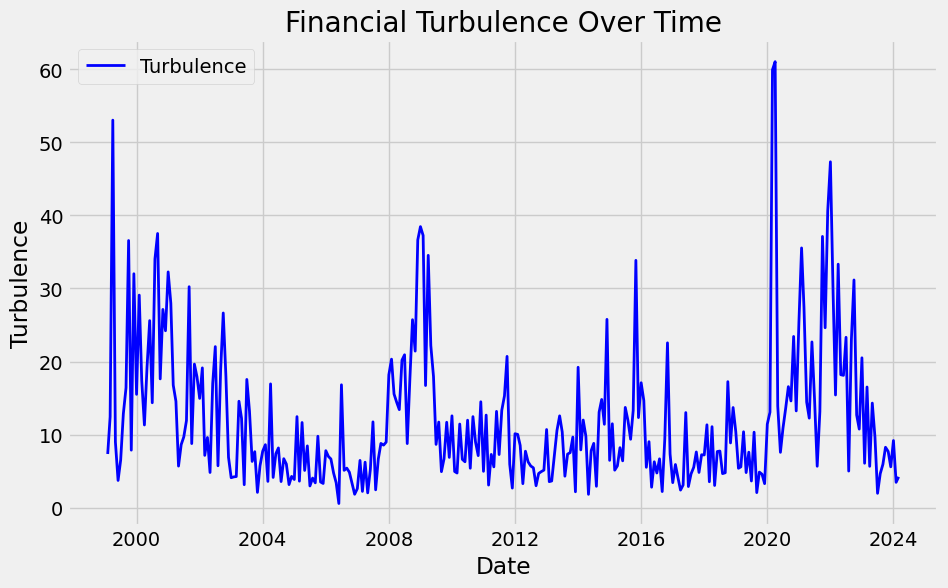

In [ ]:
# Convert index and Turbulence column to numpy arrays
dates = np.array(sectors_returns.index)
turbulence = np.array(sectors_returns['Turbulence'])

# Plot the Turbulence data
plt.figure(figsize=(10, 6))
plt.plot(dates, turbulence, color='blue', linewidth=2, label='Turbulence')
plt.title('Financial Turbulence Over Time')
plt.xlabel('Date')
plt.ylabel('Turbulence')
plt.legend()
plt.grid(True)
plt.show()

## Market Clustering


In [ ]:
sp500 = yf.download("^GSPC", start='1987-2-1', end='2024-1-1',interval='1mo')
market = sp500.loc[:,'Adj Close'].pct_change().dropna()
market.head()


[*********************100%%**********************]  1 of 1 completed


Date
1987-03-01    0.026390
1987-04-01   -0.011450
1987-05-01    0.006034
1987-06-01    0.047914
1987-07-01    0.048224
Name: Adj Close, dtype: float64

In [ ]:
def drawdown(ret):
    net_val = ret.add(1).cumprod()
    pre_peak = net_val.cummax()
    cur_drawdown = (net_val - pre_peak)/pre_peak
    return cur_drawdown

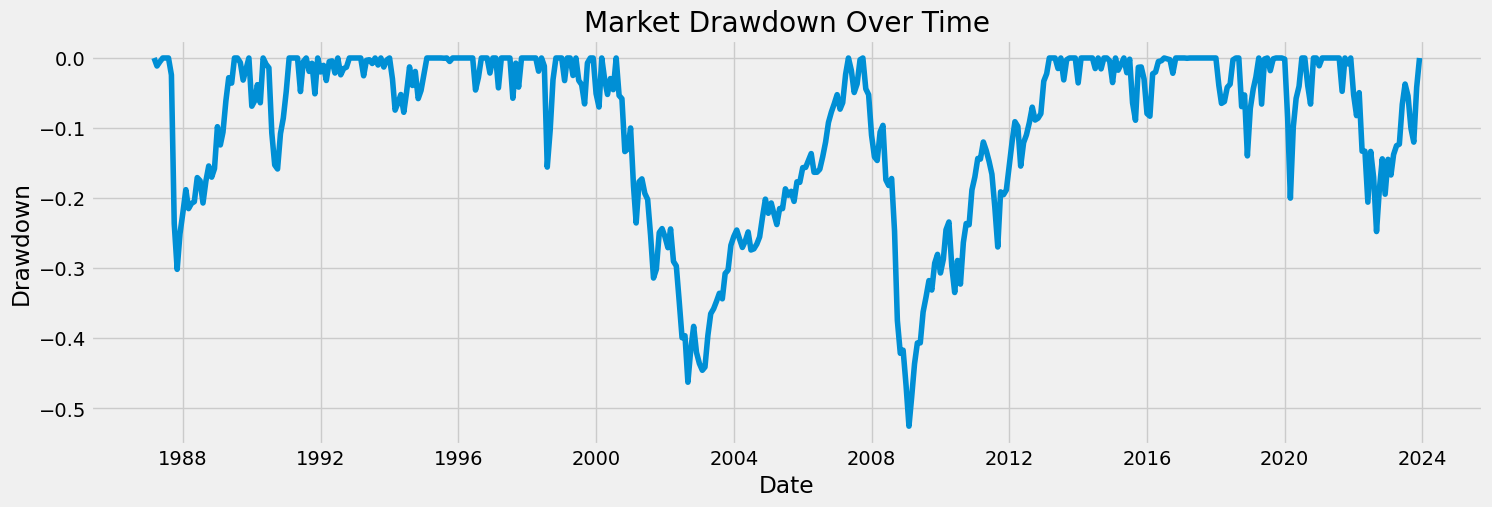

In [ ]:
dd = drawdown(market)
plt.figure(figsize=(16, 5))
plt.plot(dd)
plt.title('Market Drawdown Over Time')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.show()

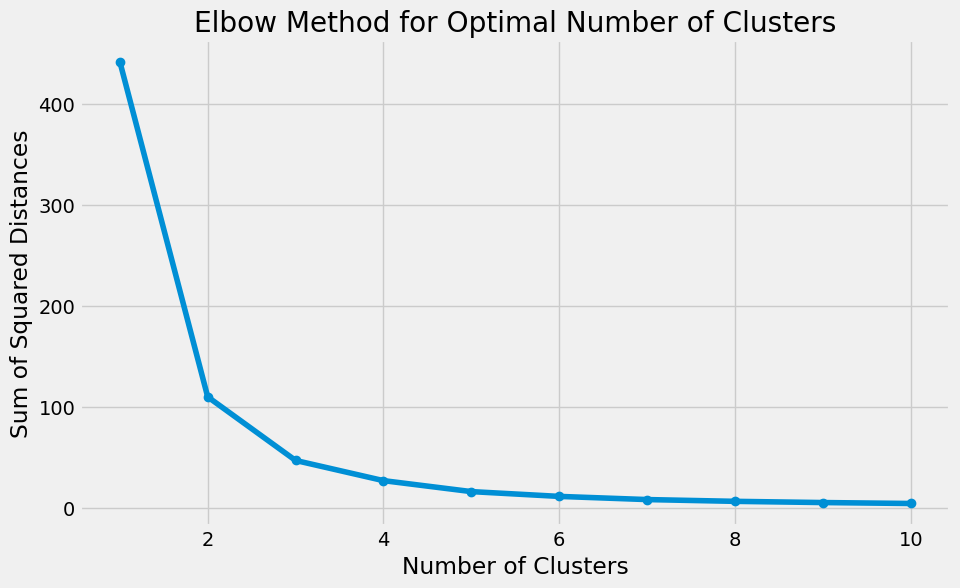

In [ ]:
X = dd.values.reshape(-1, 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=42)

In [ ]:
regime = pd.DataFrame(dd)
regime['label'] = kmeans.labels_
regime.columns = ['drawdown','label']
regime

,drawdown,label
Date,,
1987-03-01,0.000000,0
1987-04-01,-0.011450,0
1987-05-01,-0.005485,0
1987-06-01,0.000000,0
1987-07-01,0.000000,0
...,...,...
2023-08-01,-0.054241,0
2023-09-01,-0.100317,0
2023-10-01,-0.120092,1


In [ ]:
def assign_regime(cluster_label):
    if cluster_label == 0:
        return 'normal market risk regime'
    elif cluster_label == 1:
        return 'market correction regime'
    elif cluster_label == 2:
        return 'bear market regime'

regime['regime'] = regime['label'].apply(assign_regime)

In [ ]:
regime.groupby('regime').count()/len(regime)

,drawdown,label
regime,,
bear market regime,0.099548,0.099548
market correction regime,0.264706,0.264706
normal market risk regime,0.635747,0.635747


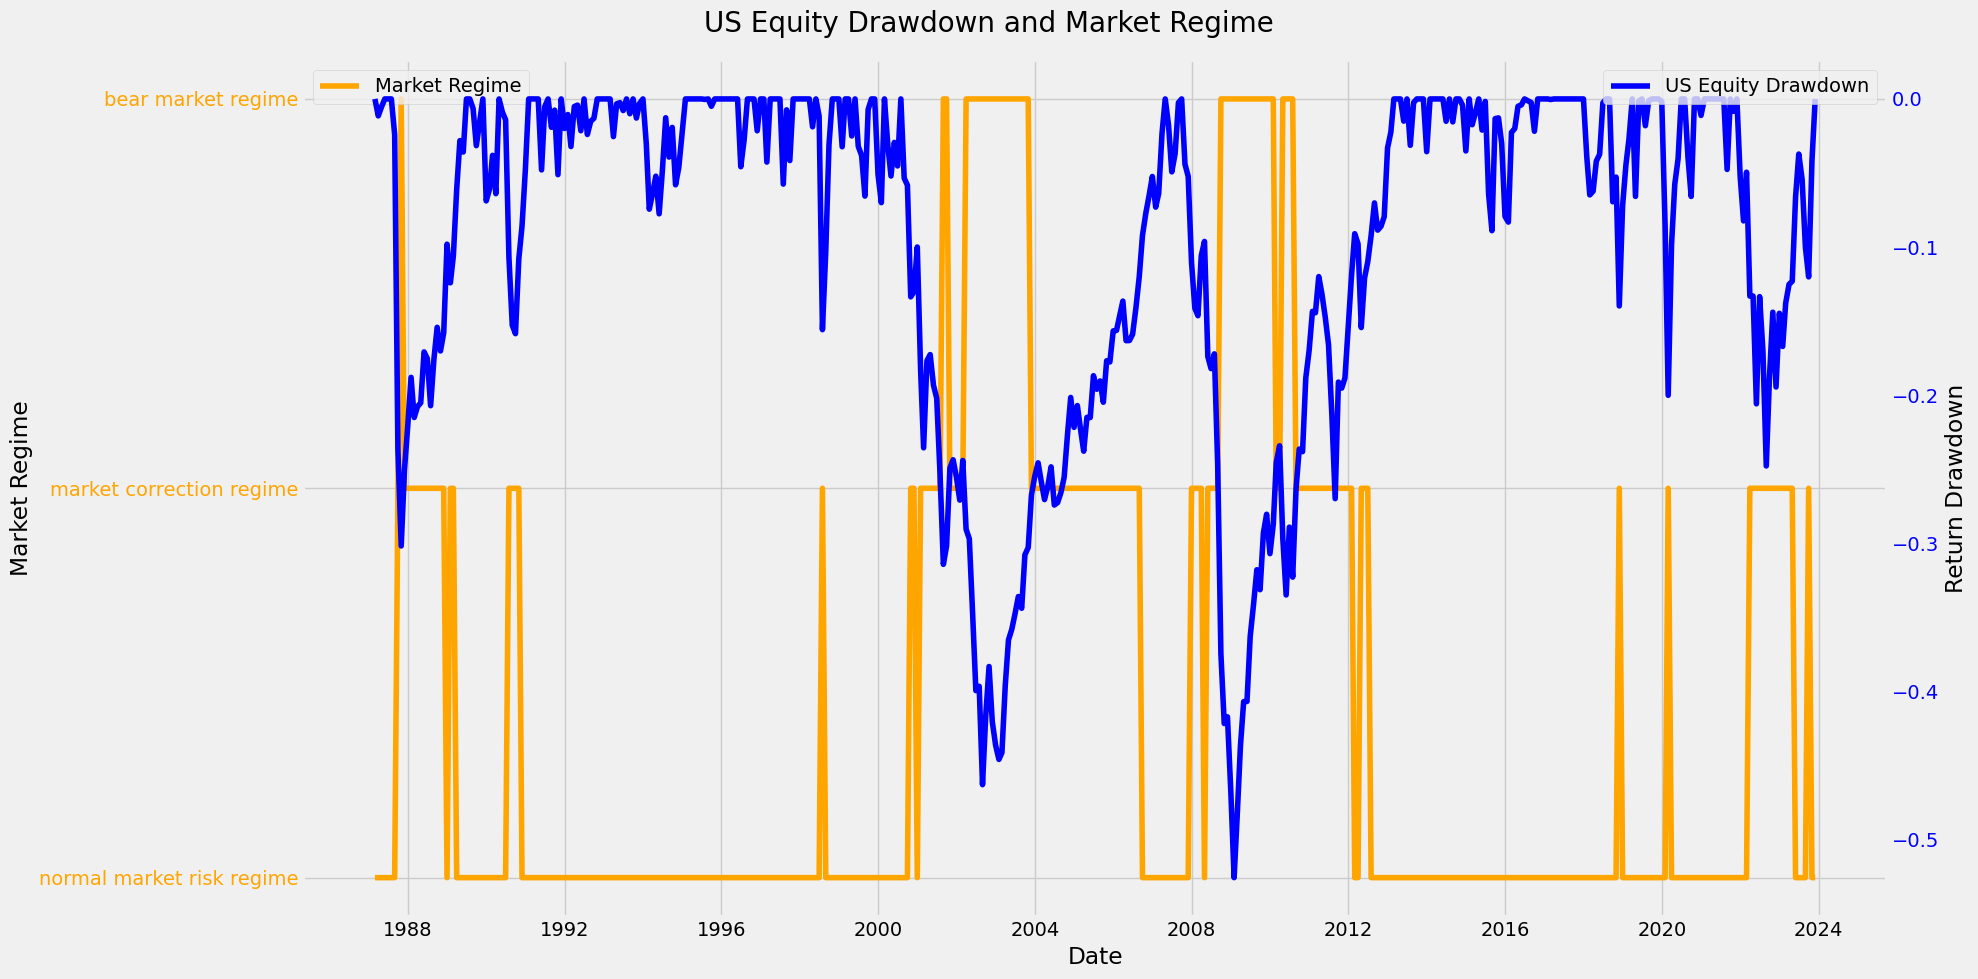

In [ ]:

fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the 'label' data on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Market Regime')
ax1.plot(regime.index, regime['label'], color='orange', label='Market Regime')
ax1.tick_params(axis='y', labelcolor='orange')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Return Drawdown')  # we already handled the x-label with ax1
ax2.plot(regime.index, regime['drawdown'], color='blue', label='US Equity Drawdown')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and grid
fig.suptitle('US Equity Drawdown and Market Regime', fontsize=20)
ax1.set_yticks([0, 1, 2])
ax1.grid(True)
ax2.grid(False)

# Optionally add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot with tight layout
fig.tight_layout()
plt.show()

## Predict Market Regime

In [ ]:
predictive_feature = pd.concat([whole_macrofactor,sectors_returns['Turbulence']], axis=1).dropna()
target = regime['label'].shift(-1)
entire_data = predictive_feature.join(target,how='inner')
entire_data

,1yr Annualized Change,10yr Annualized Change,GDP Growth,Leading,Coincident,Lagging - Unemployment,Lagging - Labor Cost,Lagging - Credit Income Ratio,Risk,Credit,Leverage,Effective Federal Funds Rate,Volatility Index,CAPE Ratio,Turbulence,label
1999-02-01,0.021524,0.033014,3.4,100.39500,83.12,13.8,82.061,0.183820,-0.353925,-0.076555,0.757827,4.764643,28.822632,40.40,7.347833,0.0
1999-03-01,0.020325,0.032667,3.4,100.56470,83.40,13.4,82.061,0.184687,-0.405983,-0.103022,0.540820,4.809355,25.309565,41.35,12.435061,0.0
1999-04-01,0.022029,0.032695,3.4,100.71340,83.63,13.3,82.061,0.185193,-0.428502,-0.113412,0.403384,4.736333,23.478571,42.70,53.038324,0.0
1999-05-01,0.020821,0.032409,5.4,100.84090,83.92,13.4,82.028,0.185978,-0.429770,-0.109940,0.445855,4.742258,26.204500,42.55,8.995298,0.0
1999-06-01,0.019630,0.032066,5.4,100.93790,84.11,14.3,82.028,0.186662,-0.365630,-0.086837,0.571000,4.764667,23.626364,42.18,3.727651,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.048552,0.028227,4.9,99.22750,139.70,20.7,119.882,0.217509,-0.370814,0.127450,0.642882,5.076333,14.003182,29.94,9.663555,0.0
2023-07-01,0.047076,0.028227,4.9,99.33507,140.08,20.6,119.882,0.217423,-0.390880,0.107582,0.491735,5.120000,13.932381,30.89,1.967099,0.0
2023-08-01,0.044128,0.028263,3.4,99.42046,140.22,20.4,119.990,0.215681,-0.438792,0.095690,0.219392,5.330000,15.853913,30.09,4.652693,0.0
2023-09-01,0.041437,0.028431,3.4,99.48235,140.61,21.4,119.990,0.215277,-0.448002,0.095146,0.088614,5.330000,15.173333,29.80,5.932727,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(entire_data.drop(columns=['label']), entire_data['label'], test_size=0.5, random_state=42)

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
pipeline_rf = Pipeline([
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_xgb = Pipeline([
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20]
}

param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [6, 10],
    'classifier__learning_rate': [0.01, 0.1]
}
scoring = {
    'f1_score': make_scorer(f1_score, average='macro'),  # For multi-class, you might use 'macro' or 'weighted'
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
}

In [ ]:
grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=tscv, scoring=scoring, refit='f1_score')
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=tscv, scoring=scoring, refit='f1_score')

# Perform the grid search
grid_search_rf.fit(X_train_resampled, y_train_resampled)
grid_search_xgb.fit(X_train_resampled, y_train_resampled)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=...
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1],
                         'classifier__max_depth': [6, 10],
                         'classifier__n_estimators': [100, 200]},
             refit='f1_score',
             scoring={'accuracy': 'accuracy',
                      'f1_score': make_scorer(f1_score, average=macro),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)})

In [ ]:
def extract_results(grid_search):
    results_df = pd.DataFrame(grid_search.cv_results_)
    filtered_columns = [key for key in results_df.columns if key.startswith('mean_test_') or key.startswith('param_')]
    return results_df.loc[:, filtered_columns]

rf_results_df = extract_results(grid_search_rf)
xgb_results_df = extract_results(grid_search_xgb)

rf_results_df['model'] = 'Random Forest'
xgb_results_df['model'] = 'XGBoost'

combined_results_df = pd.concat([rf_results_df, xgb_results_df], axis=0).reset_index(drop=True)

combined_results_df


,param_classifier__max_depth,param_classifier__n_estimators,mean_test_f1_score,mean_test_accuracy,mean_test_precision,mean_test_recall,model,param_classifier__learning_rate
0,None,100,0.861959,0.890476,0.900321,0.866106,Random Forest,NaN
1,None,200,0.865436,0.890476,0.899734,0.871363,Random Forest,NaN
2,10,100,0.861959,0.890476,0.900321,0.866106,Random Forest,NaN
3,10,200,0.865436,0.890476,0.899734,0.871363,Random Forest,NaN
4,20,100,0.861959,0.890476,0.900321,0.866106,Random Forest,NaN
5,20,200,0.865436,0.890476,0.899734,0.871363,Random Forest,NaN
6,6,100,0.791549,0.861905,0.796931,0.794612,XGBoost,0.01
7,6,200,0.881902,0.890476,0.882045,0.884133,XGBoost,0.01
8,10,100,0.791549,0.861905,0.796931,0.794612,XGBoost,0.01
9,10,200,0.881902,0.890476,0.882045,0.884133,XGBoost,0.01


In [ ]:
best_rf_model = grid_search_rf.best_estimator_
best_xgb_model = grid_search_xgb.best_estimator_

In [ ]:
grid_search_rf.best_score_, grid_search_xgb.best_score_

(0.8654362979197172, 0.8977788342498512)

In [ ]:
best_params_xgb = grid_search_xgb.best_params_
model_xgb = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = model_xgb.predict(X_test)

performance_data = {
    'Model': 'XGBoost',
    'Accuracy': [ accuracy_score(y_test, y_pred_xgb)],
    'F1 Score': f1_score(y_test, y_pred_xgb, average='macro')
}

df_performance = pd.DataFrame(performance_data)
df_performance

,Model,Accuracy,F1 Score
0,XGBoost,0.818792,0.776145


## Portfolio Optimization

In [ ]:
sector_etfs = {
    'Communication Services': 'XLC',
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Energy': 'XLE',
    'Financials': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Information Technology': 'XLK',
    'Materials': 'XLB',
    'Real Estate': 'XLRE',
    'Utilities': 'XLU'
}

# Optional end date, can set to None to use today's date
end_date = "2023-12-31"

# Initialize DataFrame to collect earliest dates
earliest_dates = pd.Series(index=list(sector_etfs.keys()))

# Check the earliest available data for each ETF
for sector, ticker in sector_etfs.items():
    etf = yf.Ticker(ticker)
    # Fetch only a few rows of data to find the earliest date
    hist = etf.history(period="max")
    earliest_dates[sector] = hist.index.min()

In [ ]:
earliest_dates

Communication Services    2018-06-19 00:00:00-04:00
Consumer Discretionary    1998-12-22 00:00:00-05:00
Consumer Staples          1998-12-22 00:00:00-05:00
Energy                    1998-12-22 00:00:00-05:00
Financials                1998-12-22 00:00:00-05:00
Health Care               1998-12-22 00:00:00-05:00
Industrials               1998-12-22 00:00:00-05:00
Information Technology    1998-12-22 00:00:00-05:00
Materials                 1998-12-22 00:00:00-05:00
Real Estate               2015-10-08 00:00:00-04:00
Utilities                 1998-12-22 00:00:00-05:00
dtype: object

In [ ]:
sector_etfs = {
    'Consumer Discretionary': 'XLY',
    'Consumer Staples': 'XLP',
    'Energy': 'XLE',
    'Financials': 'XLF',
    'Health Care': 'XLV',
    'Industrials': 'XLI',
    'Information Technology': 'XLK',
    'Materials': 'XLB',
    'Utilities': 'XLU'
}
start = "1999-01-01"
end = "2024-12-31"

# Create an empty DataFrame to hold the closing prices
sector_data = pd.DataFrame()

# Fetch historical data for each ETF and add to the DataFrame
for sector, ticker in sector_etfs.items():
    hist = yf.download(ticker, start = start, end = end)
    sector_data[sector] = hist['Adj Close']


sector_data.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Utilities
Date,,,,,,,,,
2024-04-22,170.509995,75.150002,95.589996,40.869999,139.479996,121.379997,194.250000,89.050003,66.029999
2024-04-23,172.539993,75.360001,96.120003,41.130001,141.300003,123.070000,197.130005,88.279999,66.339996
2024-04-24,174.190002,75.930000,96.190002,41.119999,140.860001,122.089996,198.029999,88.339996,66.739998
2024-04-25,174.339996,75.750000,96.629997,40.880001,139.919998,122.459999,197.600006,88.970001,66.919998
2024-04-26,175.910004,75.589996,95.739998,40.820000,139.960007,122.660004,199.830002,89.519997,66.190002


In [ ]:
ret_df = sector_data.pct_change().dropna()
ret_df.head()

,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Utilities
Date,,,,,,,,,
1999-01-05,0.016847,0.007541,-0.005358,0.009334,0.015663,0.020645,0.025568,0.024531,0.012080
1999-01-06,0.028402,0.012089,0.032997,0.031703,0.016607,0.021493,0.029548,0.017605,0.010379
1999-01-07,-0.001151,-0.011376,-0.004563,0.015365,-0.004667,-0.008664,-0.003139,-0.007612,-0.003596
1999-01-08,0.001152,-0.004028,0.004584,0.006305,0.012309,0.007491,0.004049,0.034171,0.005670
1999-01-11,-0.005178,-0.020220,-0.018905,-0.015038,0.002316,-0.009294,0.009857,0.002023,-0.026653


In [ ]:

future_regime = model_xgb.predict(predictive_feature)
future_regime = pd.DataFrame(future_regime,index = predictive_feature.index,columns=['next month regime'])
future_regime

,next month regime
1999-02-01,0
1999-03-01,0
1999-04-01,0
1999-05-01,0
1999-06-01,0
...,...
2023-06-01,0
2023-07-01,0
2023-08-01,1
2023-09-01,1


In [ ]:
future_regime.index

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01'],
              dtype='datetime64[ns]', length=166, freq='MS')

In [ ]:
future_regime[:datetime(2012,1,1)]

,next month regime
2010-01-01,2
2010-02-01,2
2010-03-01,1
2010-04-01,2
2010-05-01,2
2010-06-01,2
2010-07-01,2
2010-08-01,1
2010-09-01,1
2010-10-01,1


In [ ]:
start_date = '2012-01-01'
end_date = '2022-12-31'

month_range = pd.date_range(start=start_date, end=end_date, freq='MS')

In [ ]:
def opt(ret_df,lookback = 12,transaction_cost_rate = 0.005,gamma = 0.5,regime_detect=False):
  n_assets = len(ret_df.columns)
  w0 = np.zeros(n_assets)

  returns_record = []



  for month in month_range:
      train_start = month - relativedelta(months=lookback+1)
      train_end = month - relativedelta(months=1)


      test_start = month
      test_end = test_start + relativedelta(months=1)
      if regime_detect:
        next_regime = future_regime.loc[month]
        next_regime = int(next_regime)
        same_regime_month = regime['label'][train_start:train_end][regime['label']==next_regime]
        month_select = same_regime_month.index
        mask = ret_df.index.to_period('M').isin(month_select.to_period('M'))
        filtered_data = ret_df[mask]
        if filtered_data.empty:
          returns_record.append(0.05/12)
          continue
        Y = filtered_data
        mu = Y.mean().to_numpy()
        sigma = Y.cov().to_numpy()



      else:
        Y = ret_df[train_start:train_end]
        mu = Y.mean().to_numpy()
        sigma = Y.cov().to_numpy()

      w1 = cp.Variable(n_assets)

      ret = mu.T @ (w0 + w1)
      risk = cp.quad_form(w0 + w1, sigma)
      transaction_costs = cp.sum(cp.abs(w1)) * transaction_cost_rate
      objective = cp.Maximize(ret - gamma * risk - transaction_costs)

      constraints = [cp.sum(w0 + w1) == 1]


      prob = cp.Problem(objective, constraints)
      prob.solve()

      optimized_weights = w0 + w1.value

      if month + relativedelta(months=1) <= month_range[-1]:
            next_period_returns = ret_df[test_start:test_end]
            period_return = np.dot(optimized_weights, next_period_returns.mean())
            returns_record.append(period_return)

      w0 = optimized_weights

  return returns_record

In [ ]:
def block_resample_dataframe(data, block_size):
    n_blocks = len(data) // block_size
    data = data.iloc[:n_blocks * block_size]  # Truncate to fit complete blocks
    block_indices = np.random.choice(n_blocks, n_blocks, replace=True)
    resampled_blocks = [data.iloc[i * block_size:(i + 1) * block_size] for i in block_indices]
    resampled_data = pd.concat(resampled_blocks, ignore_index=True)
    return resampled_data

In [ ]:
gamma_val = [0.01,0.1,0.3,0.5,0.7,1]
gamma_dic = {}
time_index = ret_df.index
for gamma in gamma_val:
  np.random.seed(0) # the return sereis would be same across each gamma value
  gamma_dic[gamma] = []
  for i in tqdm(range(50)):
    temp_df = block_resample_dataframe(ret_df, 252)
    temp_df.index = time_index[:len(temp_df)]
    returns_record = opt(temp_df,gamma = gamma)
    gamma_dic[gamma].append(returns_record)

100%|██████████| 50/50 [02:16<00:00,  2.74s/it]


In [ ]:
conversion_factor = 12
summery_dic = {}
for gamma in gamma_val:
  gamma_list = gamma_dic[gamma]
  summery_dic[gamma] = {}

  summery_dic[gamma]['annualized return'] = []
  summery_dic[gamma]['annualized std'] = []
  summery_dic[gamma]['annualized sharpe'] = []
  for series in gamma_list:
    series = series[:-1]
    mean = np.mean(series)*conversion_factor
    std = np.std(series)*np.sqrt(conversion_factor)
    sharpe = mean/std
    summery_dic[gamma]['annualized return'].append(mean)
    summery_dic[gamma]['annualized std'].append(std)
    summery_dic[gamma]['annualized sharpe'].append(sharpe)

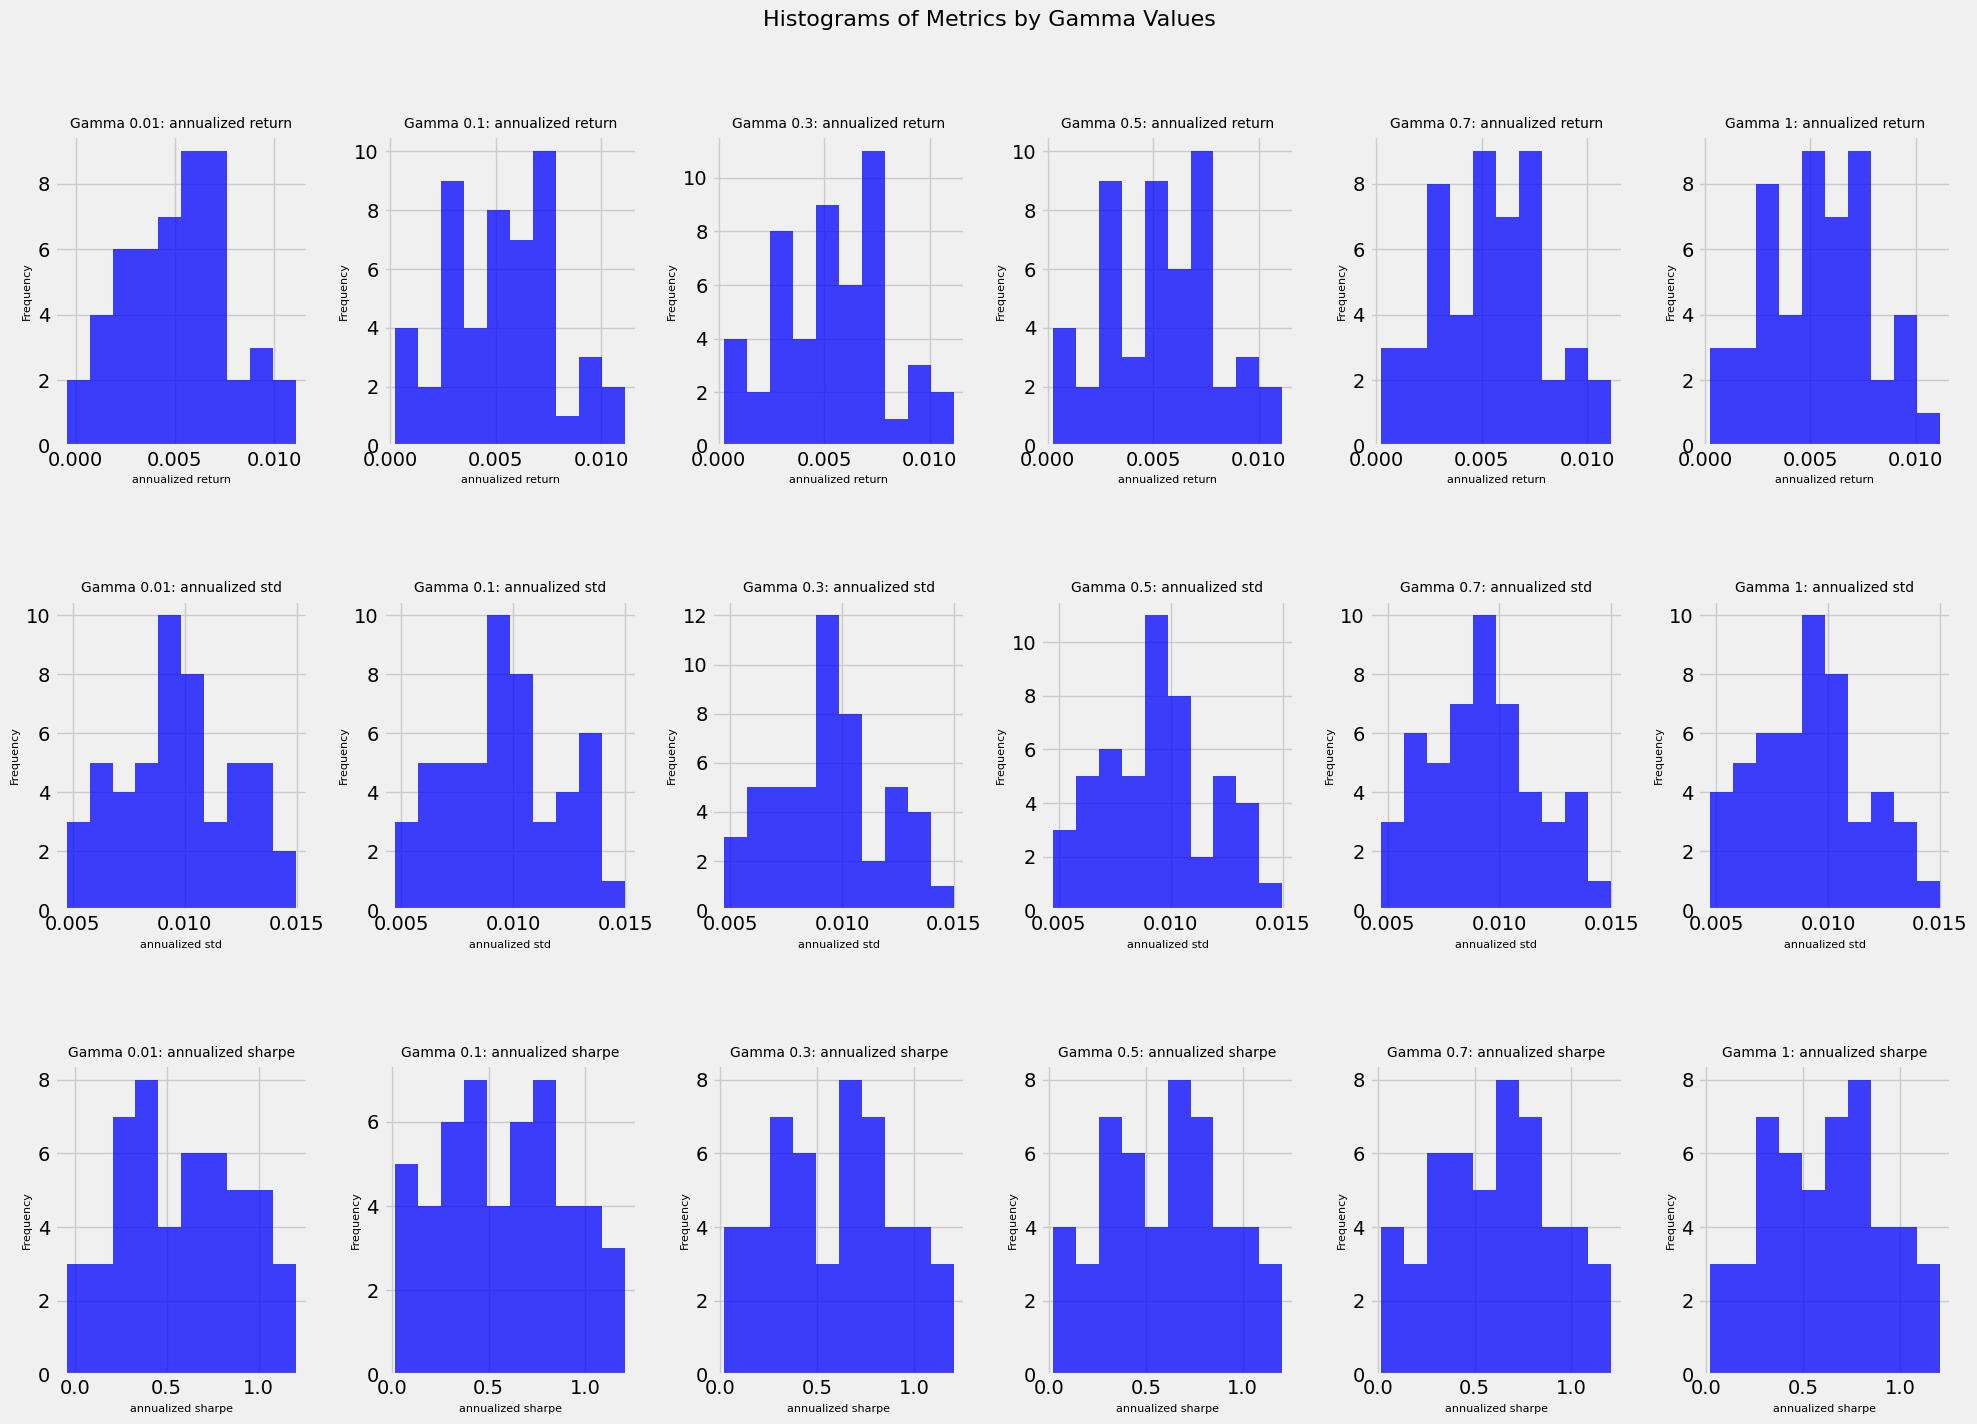

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=len(gamma_val), figsize=(20, 15))  # Increased size
fig.suptitle('Histograms of Metrics by Gamma Values', fontsize=16)

# Titles for the rows
metric_names = ['annualized return', 'annualized std', 'annualized sharpe']

for i, metric in enumerate(metric_names):
    for j, gamma in enumerate(gamma_val):
        ax = axes[i][j]
        ax.hist(summery_dic[gamma][metric], bins=10, alpha=0.75, color='blue')
        ax.set_title(f'Gamma {gamma}: {metric}', fontsize=10)
        ax.set_xlabel(metric, fontsize=8)
        ax.set_ylabel('Frequency', fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make more room
plt.subplots_adjust(wspace=0.3, hspace=0.5)  # Adjust the space between plots
plt.show()

In [ ]:
stats_dic = {}
for gamma, metrics in summery_dic.items():
    stats_dic[gamma] = {}
    annualized_returns = metrics['annualized return']
    annualized_stds = metrics['annualized std']
    annualized_shapre = metrics['annualized sharpe']

    # Calculate mean and std for annualized returns
    mean_returns = np.mean(annualized_returns)
    std_returns = np.std(annualized_returns)

    # Calculate mean and std for annualized stds
    mean_stds = np.mean(annualized_stds)
    std_stds = np.std(annualized_stds)

    # Calculate mean and std for annualized sharpe
    mean_sharpe = np.mean(annualized_shapre)
    std_sharpe = np.std(annualized_shapre)

    # Store the results in the stats dictionary
    stats_dic[gamma]['mean annualized return'] = mean_returns
    stats_dic[gamma]['std annualized return'] = std_returns
    stats_dic[gamma]['mean annualized std'] = mean_stds
    stats_dic[gamma]['std annualized std'] = std_stds
    stats_dic[gamma]['mean annualized sharpe'] = mean_sharpe
    stats_dic[gamma]['std annualized sharpe'] = std_sharpe
    stats_dic[gamma]['sharpe of annualized sharpe'] = mean_sharpe/std_sharpe

df = pd.DataFrame.from_dict(stats_dic, orient='index')
df.index.name = 'Gamma'
df.reset_index(inplace=True)

In [ ]:
df.sort_values(by='sharpe of annualized sharpe',ascending = False)

,Gamma,mean annualized return,std annualized return,mean annualized std,std annualized std,mean annualized sharpe,std annualized sharpe,sharpe of annualized sharpe
5,1.00,0.005349,0.002516,0.009234,0.002384,0.614575,0.301914,2.035594
4,0.70,0.005335,0.002544,0.009313,0.002379,0.608032,0.303564,2.002980
3,0.50,0.005316,0.002544,0.009384,0.002377,0.602638,0.305102,1.975204
2,0.30,0.005298,0.002542,0.009468,0.002366,0.597676,0.307324,1.944771
1,0.10,0.005236,0.002548,0.009618,0.002487,0.586604,0.312075,1.879689
0,0.01,0.005149,0.002663,0.009748,0.002524,0.573833,0.326496,1.757549


In [ ]:
ret_df.mean(axis=1)

Date
1999-01-05    0.014094
1999-01-06    0.022314
1999-01-07   -0.003267
1999-01-08    0.007967
1999-01-11   -0.009010
                ...   
2024-04-22    0.007011
2024-04-23    0.007161
2024-04-24    0.001979
2024-04-25    0.000138
2024-04-26    0.000521
Length: 6369, dtype: float64

In [ ]:
regime_detect_return = opt(ret_df,lookback=12,gamma = 1,regime_detect=True)
normal_return = opt(ret_df,lookback=12, gamma = 1,regime_detect=False)


In [ ]:
summary_df = pd.DataFrame(index=month_range[:-1])
summary_df['regime detection'] = regime_detect_return
summary_df['classic optimization'] = normal_return
netval_df = (1+summary_df).cumprod()
netval_df

,regime detection,classic optimization
2012-01-01,0.998438,0.998438
2012-02-01,1.002598,0.998854
2012-03-01,1.006775,0.999482
2012-04-01,1.007874,1.000573
2012-05-01,1.007945,1.000643
...,...,...
2022-07-01,1.068371,1.050585
2022-08-01,1.069276,1.051474
2022-09-01,1.063348,1.045646
2022-10-01,1.064672,1.046948


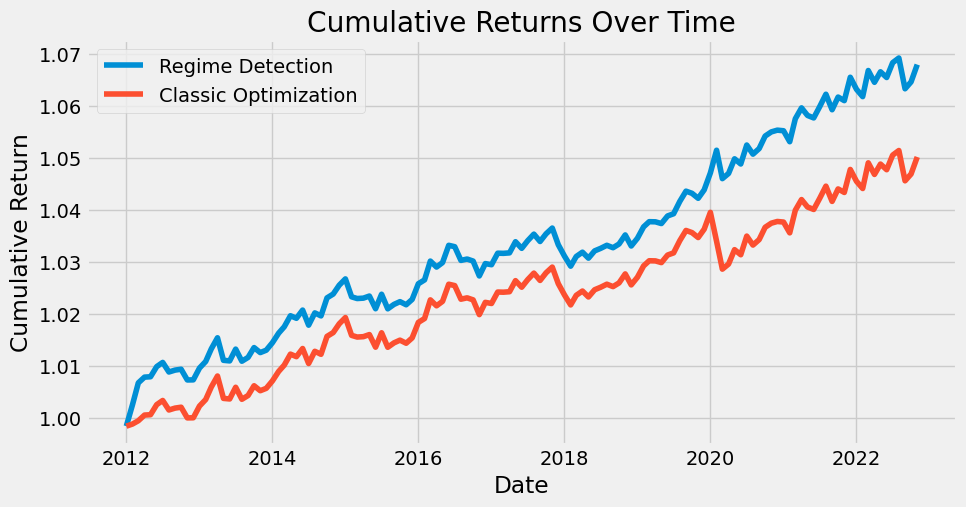

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(netval_df['regime detection'], label='Regime Detection')
plt.plot(netval_df['classic optimization'], label='Classic Optimization')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

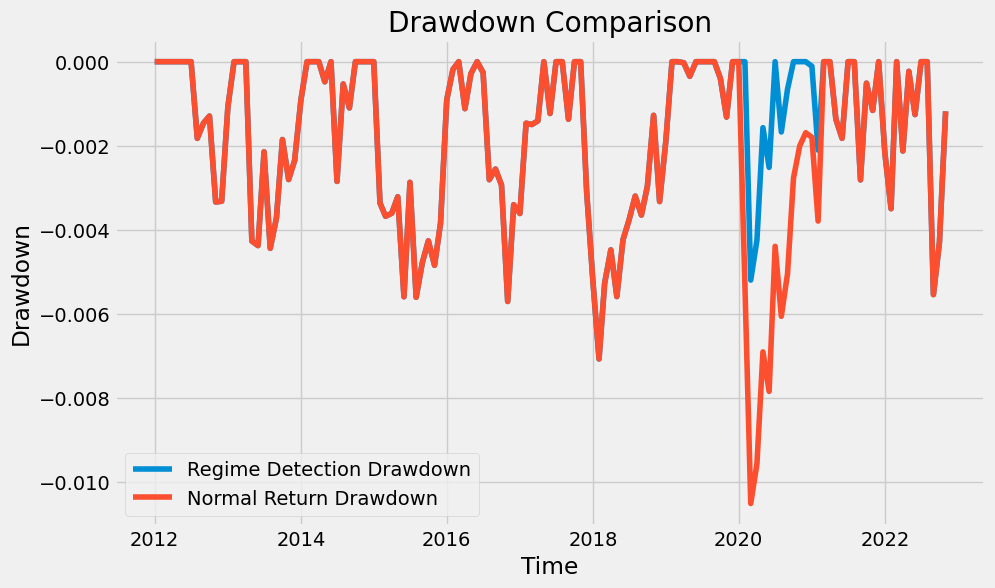

In [ ]:
detect_dd = drawdown(summary_df['regime detection'])
normal_dd = drawdown(summary_df['classic optimization'])
plt.figure(figsize=(10, 6))
plt.plot(detect_dd, label='Regime Detection Drawdown')
plt.plot(normal_dd, label='Normal Return Drawdown')
plt.title('Drawdown Comparison')
plt.xlabel('Time')
plt.ylabel('Drawdown')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def maxdd(ret):
  return drawdown(ret).min()

def calmar(ret):
  return ret.mean()*12/abs(maxdd(ret))

def sharpe(ret):
  return (ret.mean()/ret.std())*np.sqrt(12)

In [ ]:
performance = summary_df.agg([maxdd,calmar,sharpe]).T
performance

,maxdd,calmar,sharpe
regime detection,-0.007075,0.855420,0.877166
classic optimization,-0.010516,0.429224,0.659372
